[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AndReGeist/wandb_cluster_neuralode/blob/main/colab/basic_example.ipynb#scrollTo=qXAp1blGadTl)

# Basic example: Use "Weights and biases" with JAX

In this notebook, we track the training process of a neural ODE regression using [weight and biases](https://wandb.ai/site).

⚠️ The NeuralODE code below is copied and then altered from the example provided in the [Diffrax  git repo](https://docs.kidger.site/diffrax/examples/neural_ode/). If you happen to use Diffrax in your academic research kindly consider [citing the library](https://docs.kidger.site/diffrax/).

The code below got inspired by the blogposts:
- [Weights and biases: Quickstart](https://docs.wandb.ai/quickstart)
- [A complete Weights and Biases tutorial](https://theaisummer.com/weights-and-biases-tutorial/)
- [Writing a training loop in JAX and Flax](https://wandb.ai/jax-series/simple-training-loop/reports/Writing-a-Training-Loop-in-JAX-and-Flax--VmlldzoyMzA4ODEy)

In [57]:
!pip install -q equinox diffrax optax

In [58]:
import time

import diffrax  # https://docs.kidger.site/diffrax/
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

## Setting up dynamics and NeuralODE
We use...
- JAX, providing linear algebra with automatic differentiation and GPU acceleration
- Equinox to build neural networks
- Optax for optimisers
- Diffrax for ODE solvers

Define a NN that models an ODE...

In [59]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

Wrap the ODE solver into a model...

In [60]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

Toy dataset of nonlinear oscillators. Sample paths look like deformed sines and cosines.

In [61]:
def _get_data(ts, *, key):
    y0 = jrandom.uniform(key, (2,), minval=-0.6, maxval=1)

    def f(t, y, args):
        x = y / (1 + y)
        return jnp.stack([x[1], -x[0]], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 10, 100)
    key = jrandom.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [62]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

## Setup wandb
Before setting up the data set and training loop, we install the weights and biases library and login with our account...



In [63]:
!pip install -q wandb
!wandb login

wandb: Currently logged in as: rene-geist. Use `wandb login --relogin` to force relogin


In [64]:
import wandb
import pickle
import os

## Create data and log with wandb
Data sets (as well as models) can be stored in wandb as [artifact](https://docs.wandb.ai/guides/data-and-model-versioning) being simply folders with files on the wandb server. This [Google Colab](https://colab.research.google.com/drive/1GM22vkt1BXm3JVpTX8QeG1E2Rwl7xr_0?usp=sharing) illustrates working with artifacts. Wandb checksums the artifact to identify changes and track new versions.

Artifacts are useful for...
- [data versioning](https://docs.wandb.ai/guides/data-and-model-versioning/dataset-versioning)
- [model versioning](https://docs.wandb.ai/guides/data-and-model-versioning/model-versioning)

In [65]:
def create_dataset(seed=42, size_train=256, size_test=256):

    # ==== Initialize W&B run to track job ==== #
    config = {
        "size_train": size_train,
        "size_test": size_test,
        "seed": seed
    }
    run = wandb.init(project="wandb_cluster_neuralode", job_type="dataset-creation", config=config)

    key = jrandom.PRNGKey(seed)
    key_train, key_test = jrandom.split(key, 2)
    ts, ys = get_data(size_train, key=key_train)
    ts_test, ys_test = get_data(size_test, key=key_test)
    _, length_size, data_size = ys.shape

    data = {"ts": ts, 
            "ys": ys, 
            "length_size": length_size, 
            "data_size": data_size,
            "ts_test": ts_test, 
            "ys_test": ys_test}

    with open('data.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    dataset = wandb.Artifact('my-dataset', type='dataset')  # Create new artifact
    dataset.add_file("data.pickle")  # Add files to artifact
    run.log_artifact(dataset)  # Log artifact to save it as an output of this run

    wandb.finish()  # Finish session

## Training loop
In the training loop, we use wandb to...

1. Load the dataset   
2. log the optimization configurations
3. log optimization data
4. log model gradients

In [66]:
def main(        
        batch_size=32,
        lr_strategy=(3e-3, 3e-3),
        steps_strategy=(500, 500),
        length_strategy=(0.1, 1),
        width_size=64,
        depth=2,
        seed=5678,
        plot=True,
        print_every=100,
        watch_run = False
):

    # Define a config dictionary object
    config = {
      "batch_size": batch_size,
      "lr_strategy": lr_strategy,
      "steps_strategy": steps_strategy,
      "length_strategy": length_strategy,
      "width_size": width_size,
      "depth": depth,
      "seed": seed,
      "print_every": print_every
    }

    # ==== Initialize W&B run to track job ==== #
    run = wandb.init(
              project="wandb_cluster_neuralode",
              job_type="basic_example",
              config=config
    ) 
    # You can explicitly state to which team wandb will save data by adding the option entity='<Team name>'



    # ==== wandb - load data artifact ==== #
    artifact = run.use_artifact('my-dataset' + ':latest')
    artifact_dir = artifact.download()
    
    data_path = os.path.join(artifact_dir, 'data.pickle')
    with open(data_path, 'rb') as handle:
      data = pickle.load(handle)

    # ==== JAX - init model ==== #
    key = jrandom.PRNGKey(seed)
    model_key, loader_key = jrandom.split(key, 2)
    model = NeuralODE(data["data_size"], width_size, depth, key=model_key)


    # === Training loop === #
    # Until step 500 we train on only the first 10% of each time series.
    # This is a standard trick to avoid getting caught in a local minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state, grads, updates

    def pytree_leaves_to_dict(pytree_obj, name='array', pick_ndarrays=True):
      # wandb - To log the ndarrays of a JAX pytree, we need to extract the ndarrays, 
      # transform them to numpy arrays and save these in a dict.
      # Rightnow, I did not figure out how to give these arrays an informative name
      leaves = jax.tree_util.tree_leaves(pytree_obj)
      for k, leaf in enumerate(leaves):
          if isinstance(leaf, jax.numpy.ndarray):
              key_name = name + str(k)
              log_dict[key_name] = np.array(leaf)
      return log_dict

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = data["ts"][: int(data["length_size"] * length)]
        _ys = data["ys"][:, : int(data["length_size"] * length)]
        for step, (yi,) in zip(
                range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss_train, model, opt_state, grads, updates = make_step(_ts, yi, model, opt_state)
            end = time.time()

            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss_train}, Computation time: {end - start}")

                # Test model
                loss_test, _ = grad_loss(model, data["ts_test"], data["ys_test"])

                # === wandb - log optimization === #
                log_dict = {
                  'step': step, 
                  'loss_train': loss_train,
                  'loss_test': loss_test, 
                  'computation time': end - start
                }
              
                if watch_run:
                    log_dict.update( pytree_leaves_to_dict(model, name='model_array') )
                    #log_dict.update( pytree_leaves_to_dict(grads, name='grad_array') )
                    log_dict.update( pytree_leaves_to_dict(updates, name='updates_array') )

                wandb.log( log_dict )
          
    if plot:
        plt.plot(data["ts"], data["ys"][0, :, 0], c="dodgerblue", label="Real")
        plt.plot(data["ts"], data["ys"][0, :, 1], c="dodgerblue")
        model_y = model(data["ts"], data["ys"][0, 0])
        plt.plot(data["ts"], model_y[:, 0], c="crimson", label="Model")
        plt.plot(data["ts"], model_y[:, 1], c="crimson")
        plt.legend()
        plt.tight_layout()
        plt.savefig("neural_ode.png")
        plt.show()

    wandb.finish()  # Finish wandb session

wandb:   1 of 1 files downloaded.  


Step: 0, Loss: 0.11333475261926651, Computation time: 27.156761407852173
Step: 100, Loss: 0.007018388248980045, Computation time: 0.004298686981201172
Step: 200, Loss: 0.007753062527626753, Computation time: 0.007058143615722656
Step: 300, Loss: 0.003183433087542653, Computation time: 0.008812904357910156
Step: 400, Loss: 0.0008427510038018227, Computation time: 0.005503177642822266
Step: 499, Loss: 0.0011529180919751525, Computation time: 0.005405902862548828
Step: 0, Loss: 0.03783680498600006, Computation time: 16.89168953895569
Step: 100, Loss: 0.007608955726027489, Computation time: 0.03318452835083008
Step: 200, Loss: 0.008614838123321533, Computation time: 0.03417205810546875
Step: 300, Loss: 0.0058342753909528255, Computation time: 0.034703969955444336
Step: 400, Loss: 0.003502139588817954, Computation time: 0.03692746162414551
Step: 499, Loss: 0.009178807027637959, Computation time: 0.03650999069213867


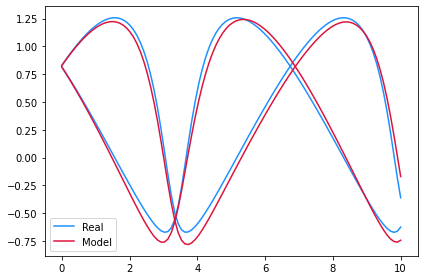

computation time,█▁▁▁▁▁▅▁▁▁▁▁
loss_test,▁▁▁▁▁▁█▁▁▁▁▁
loss_train,█▁▁▁▁▁▃▁▁▁▁▂
step,▁▂▄▅▇█▁▂▄▅▇█
computation time,0.03651
loss_test,0.00371
loss_train,0.00918
step,499


In [67]:
create_dataset(seed=42)
main(seed=99, watch_run=False)

## Automize parameter search using weights & biases "sweeps"
Use Weights & Biases [Sweeps](https://docs.wandb.ai/guides/sweeps) to automate hyperparameter search and explore the space of possible models.

